
Object Detection From TF2 Saved Model
=====================================


In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## LoadModel

In [16]:
import pathlib
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

# model_dir = "/tf/work/models/efficientdet_d0_coco17/exported_model/"
# PATH_TO_SAVED_MODEL = pathlib.Path(model_dir)/"saved_model"
# PATH_TO_SAVED_MODEL = "/tf/work/models/efficientdet_d0_coco17/exported_model/saved_model"
PATH_TO_SAVED_MODEL = "/tf/work/models/second/exported_model/saved_model"


# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

## Load label

In [17]:
PATH_TO_LABELS = '/tf/work/data/tf_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [18]:
import glob
test_image_dir = '/tf/work/data/test_images'
IMAGE_PATHS = sorted(glob.glob(test_image_dir + '/*.jpg'))

Running inference for /tf/work/data/test_images/IMG_6545.jpg... Done
Running inference for /tf/work/data/test_images/IMG_6546.jpg... Done
Running inference for /tf/work/data/test_images/IMG_6547.jpg... Done
Running inference for /tf/work/data/test_images/IMG_6548.jpg... Done
Running inference for /tf/work/data/test_images/IMG_6549.jpg... Done


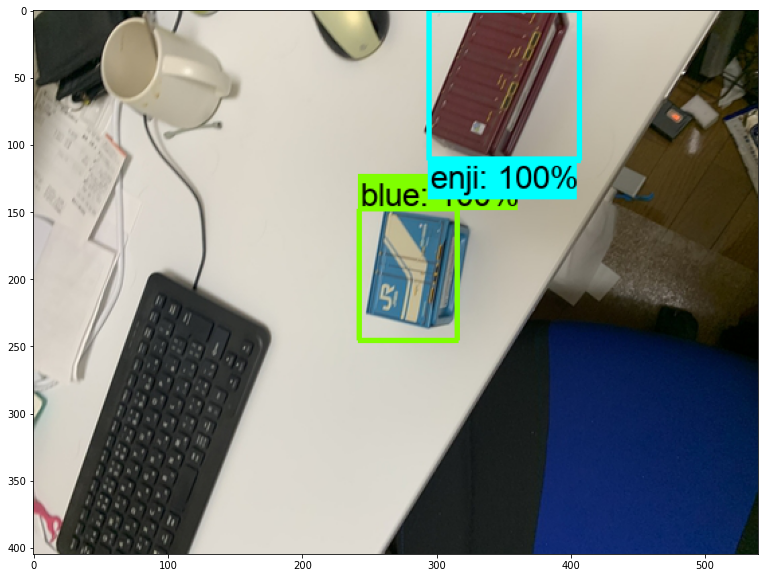

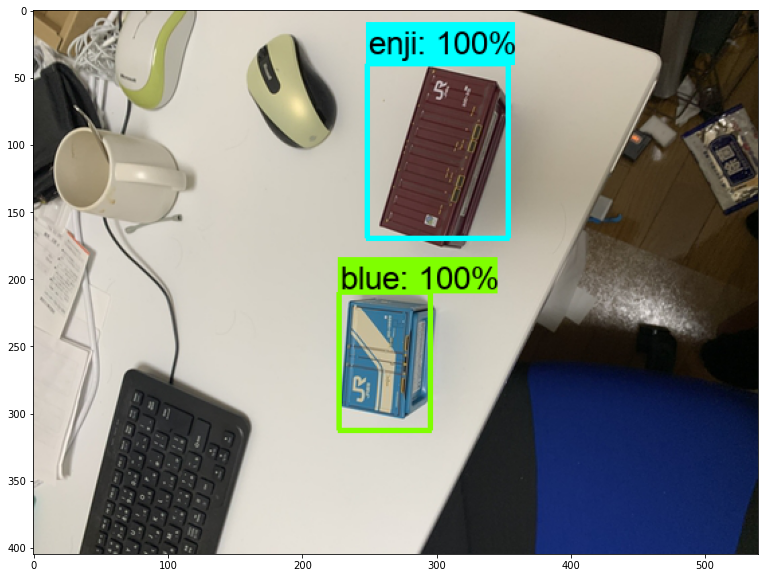

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
os.environ['MPLCONFIGDIR'] = '/opt/myapplication/.config/matplotlib' # because of deny write .config/matplotlib which is cache dir
%matplotlib inline
plt.rcParams['figure.figsize'] = (20 ,10) #set display image size 


def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.85,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2